Hello there, could you look at the tablet please?
priors:
I:
[ 0.5  0.5]
F:
[[ 0.76043982  0.23956018]
 [ 0.11394833  0.88605167]]
G:
[[ 0.5  0.5]
 [ 0.5  0.5]]
A:


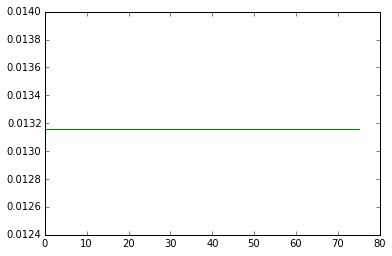

H:


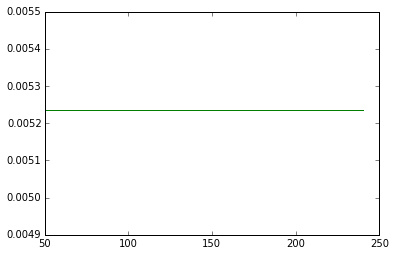

T:


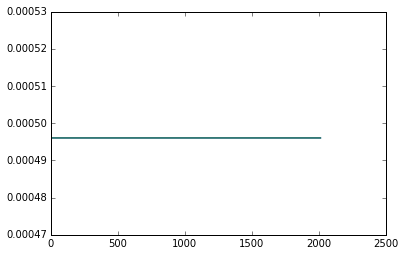

name :Chris_Wallbridge face_result: 4.85288222027e-05
name :Bahar_Irfan face_result: 0.234449492287
face_result
[0.00020694768328195426, 0.999793052316718]
1.0
1.0
2.0
gender_result
[0.5, 0.5]
evidence age:


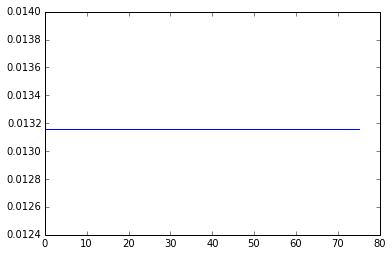

evidence height:


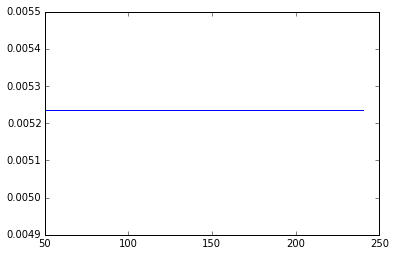

evidence time:


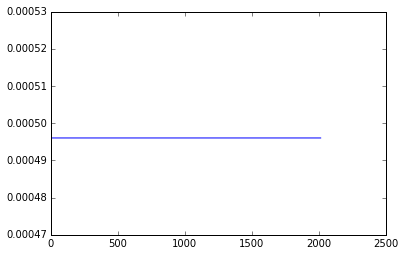

ie.posterior(self.I):
<I:Chris_Wallbridge> :: 0.212932 /<I:Bahar_Irfan> :: 0.787068
ie.posterior(self.F):
<F:Chris_Wallbridge> :: 0.000160767 /<F:Bahar_Irfan> :: 0.999839
ie.posterior(self.G):
<G:Female> :: 0.5 /<G:Male> :: 0.5
ie.posterior(self.A):


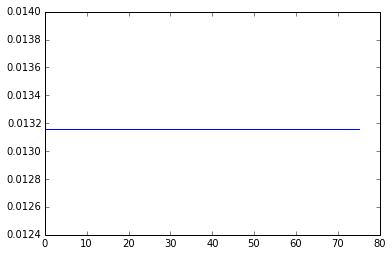

ie.posterior(self.H):


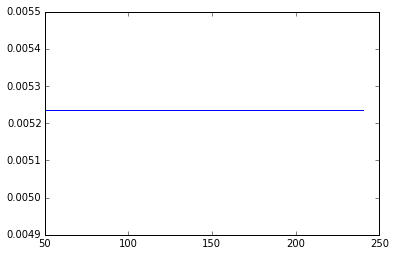

ie.posterior(self.T):


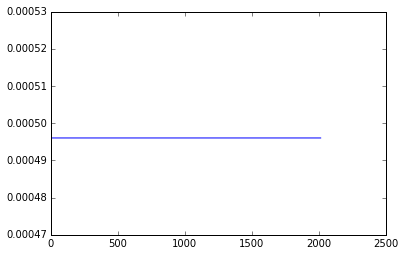

Hello Bahar, it is nice to see you again! Could you confirm that it is you please?
Bahar_Irfan
here
priors:
I:
[ 0.5  0.5]
F:
[[ 0.76043982  0.23956018]
 [ 0.11394833  0.88605167]]
G:
[[ 0.5  0.5]
 [ 0.5  0.5]]
A:


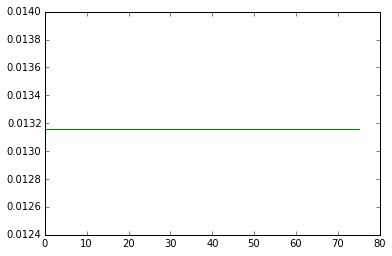

H:


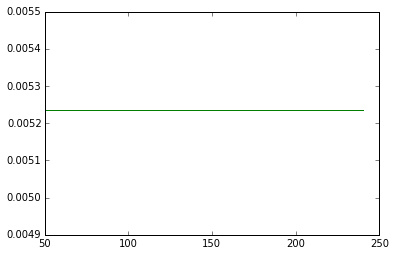

T:


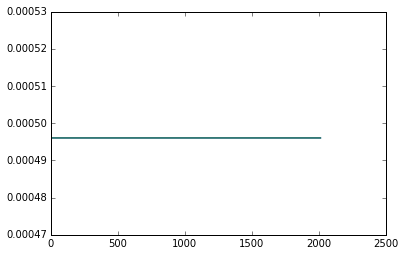

name :Chris_Wallbridge face_result: 4.85288222027e-05
name :Bahar_Irfan face_result: 0.234449492287
face_result
[0.00020694768328195426, 0.999793052316718]
1.0
1.0
2.0
gender_result
[0.5, 0.5]
evidence age:


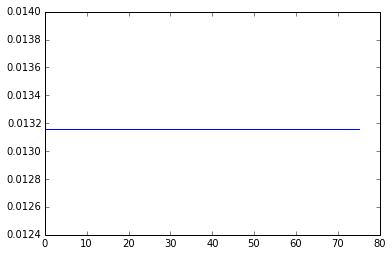

evidence height:


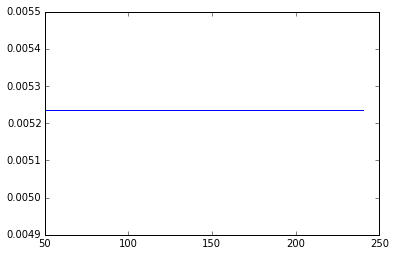

evidence time:


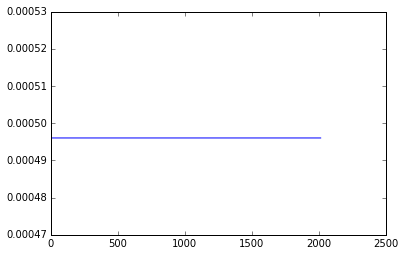

ie.posterior(self.I):
<I:Chris_Wallbridge> :: 0.212932 /<I:Bahar_Irfan> :: 0.787068
ie.posterior(self.F):
<F:Chris_Wallbridge> :: 0.000160767 /<F:Bahar_Irfan> :: 0.999839
ie.posterior(self.G):
<G:Female> :: 0.5 /<G:Male> :: 0.5
ie.posterior(self.A):


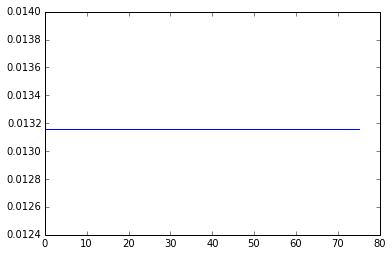

ie.posterior(self.H):


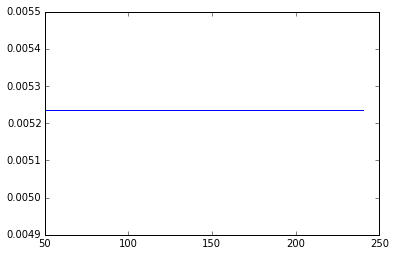

ie.posterior(self.T):


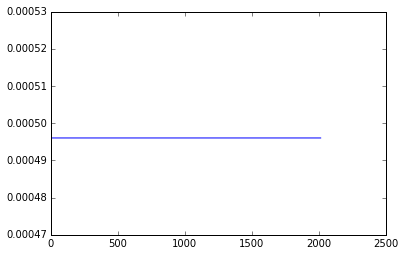

OutOfBounds: /home/bahar/Library/aGrUM/wrappers/pyAgrum/../../src/agrum/variables/labelizedVariable_inl.h:142: label 'Anne_Hathaway' is unknown in I<Chris_Wallbridge,Bahar_Irfan>

In [6]:
# coding: utf-8
%matplotlib inline
import sys
# TODO: check with windows 
sys.path.insert(0, '../../db')
sys.path.insert(0, '../../cam')
import os
import os.path

from pylab import *
import matplotlib.pyplot as plt
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

# from scipy.stats import norm

import qi

import pandas

import math

import glob

import database as db

import photo_handler
    
from datetime import datetime

import csv

import ast

import time


import threading

import logging

import random # for making random choices for the phrases

import json

from collections import OrderedDict

"""in the no-robot condition don't run this script"""
class RecogniserBN:
    
    def __init__(self):
        np.set_printoptions(threshold=np.nan)
        self.useSpanish = False
        self.isImageFromTablet = False
        
        self.recog_file = "RecogniserBN.bif"
        self.csv_file = "RecogniserBN.csv"
        self.analysis_file = "Analysis.json"
        self.db_file = "db.csv"
        self.node_names = ["I", "F", "G", "A", "H", "T"]
        self.prob_threshold = 0.000001 # the probability below 0.000001 is regarded as 0.000001
        self.init_min_threshold = 0.000001
        self.max_threshold = 0.99
        self.conf_threshold = 0.01 #the recognition confidence below 0.01 is regarded as 0.01 and all the probabilities are equal
        # TODO: determine weights      
#         self.weights = [1.0, 0.6, 0.4, 0.2, 0.8]
        self.weights = [1.0, 0.0, 0.0, 0.0, 0.0]
        self.conf_min_identity = 0.2 # minimum confidence of the identity recognition
        
        self.g_labels = ["Female", "Male"]

        self.age_min = 0
        self.age_max = 75
        self.stddev_age = 2

        self.height_min = 50 # TODO: LOOK AT THIS
        self.height_max = 240 # TODO: LOOK AT THIS
        self.stddev_height = 5 # TODO: LOOK AT THIS
        self.height_curve_interval = 47 # TODO: change this if stddev_height changes
        
        self.period = 5 # time is checked every 5 minutes 
        self.stddev_time = 15/self.period # 15 minutes
        self.time_min = 0
        self.time_max = (7*24*60/self.period) -1 # 7(days)*24(hours)*60(minutes)/self.period ( = num_time_slots)
        
        # TODO: change this if stddev_time or period changes
        if self.period == 1:
            self.time_curve_interval = 135
        else:
            self.time_curve_interval = 135/self.period + 2

# # # # #         self.l_labels = ["Kitchen", "Office"] 

        self.identity_est = ""
        self.recog_results = []
        self.isRegistered = True
        self.isMemoryRobot = True
        self.areParametersLearned = False
        self.isBNLoaded = False
        self.evidence = []
        self.ie = None
        """
        Nodes explained: 

        Identity: John, Jim, Mary..
        Range variable because it is easier to change the number of states of the node as the database grows
        Identity doesn't have "unknown" state. If argmax(P(I|Xi))< self.conf_min_identity or argmax(P(I|Xi)) == 1/num_people 
        where Xi are the attributes, then I is unknown.        
        
        Face: John's face, Jim's face, Mary's face..        
        See "Identity" variable explanation

        Gender: Labelized variable. Female (0 in Naoqi), Male (1 in Naoqi) 

        Age: Range variable in [0, 75] (because Naoqi age detection is in the range of [0,75] )
        !!!!!TONY: USE GAUSSIAN FOR P(AGE=a_i)!!!!!
        !!!!!NOTE: should I decrease the range?!!!!!
        !!!!!NOTE2: P(I=John|A=26) = this should be a Gaussian curve at mean 26, 
        since John can be 25 and the algorithm might be mistaken. I need to check this!!!!!
        !!!!!NOTE3: should I use labelized variable instead? Like 0-10, 10-20, 20-30, etc. or smaller ranges? But in that case
        P(A=26) = 40% will not be valid (should be higher confidence)!!!!!
        
        Height: Range variable [50, 240]
        !!!!!TONY: USE GAUSSIAN FOR P(HEIGHT=h_i) (DON'T USE INTERVALS, USE REAL HEIGHT)!!!!!
        "80-90, 91-100, 101-110, 111-120, 121-130, 131-140, 141-150, 151-160, 161-170, 171-180, 
        181-190, 191-200, 201-210, 211-220, 221-230, 231-240"
            or
        "child, very short, short, normal, tall, very tall"
        !!!!!NOTE: height can be changed into a range variable, 
        but it is more reliable to categorise it in this way, I need to check this!!!!

        Location: Range variable (can be changed to labelized variable). 
        Kitchen, bedroom, living room, office (the places can change depending on the experiment)
        !!!!!NOTE_COLOMBIA: Not used as the location is the same!!!!!
        
        Time: Range variable
        !!!!!TONY: USE GAUSSIAN PDF FOR P(TIME=t_i). t_i can be minutes!!!!! 
        !!!!!NOTE_COLOMBIA: Each patient has a certain timeslot and a day so this is possible to use!!!!!
        !!!!!NOTE2:7(days)*24(hours)*60(minutes)/5(period) =  - I can change this to 7(days)*6(timeslots in day) = 42
        Time slots: early morning (5.00.01 - 8.00.00), morning (8.00.01 - 12.00.00), afternoon (12.00.01 - 17.00.00), 
        evening (17.00.01 - 21.00.00), night (21.00.01 - 00.00.00), late night (00.00.01 - 5.00.00)!!!!!
        """
        
    def connectToRobot(self, ip, port=9559, useSpanish = True, isImageFromTablet = True):
        self.robot_ip = ip
        self.robot_port = port
        self.session = qi.Session()
        try:
            self.session.connect("tcp://" + ip + ":" + str(port))
        except RuntimeError:
            logging.debug("Can't connect to Naoqi at ip \"" + ip + "\" on port " + str(port) +".\n"
               "Please check your script arguments. Run with -h option for help.")
            sys.exit(1)
        self.animatedSpeechProxy = self.session.service("ALAnimatedSpeech")
        self.tts = self.session.service("ALTextToSpeech")
        self.configuration = {"bodyLanguageMode":"contextual"}
        self.useSpanish = useSpanish
        self.recog_service = self.session.service("RecognitionService")
        self.isImageFromTablet = isImageFromTablet
        self.recog_service.initSystem(self.useSpanish, self.isImageFromTablet) # initialize the robot breathing, height offset, and language
        
    def learnParameters(self, csv_file):
        # TODO: add location ast.literal_eval and append it to df when L (location) is used!

        df=pandas.read_csv(csv_file, converters={"F": ast.literal_eval, "G": ast.literal_eval, "A": ast.literal_eval, "H": ast.literal_eval})
        self.df_orig = df.copy()
        self.df_I = set(df['I'].values.tolist())
        accuracy_db = 2.0 # in recognition the confidence can be 1.0, hence I use 2.0 to differentiate from recognition
        for counter in range(0,len(self.i_labels)):
            
            li_f = [math.pow(self.init_min_threshold,self.weights[0]) for x in range(0, len(self.i_labels))]
            
            li_f[counter] = math.pow(1 - ((len(self.i_labels)-1)*math.pow(self.init_min_threshold,self.weights[0])),self.weights[0])
            li_f = [float(i)/sum(li_f) for i in li_f]
            
            accuracy = 1.0
            list_f = [[self.i_labels[x],li_f[x]] for x in range(0, len(self.i_labels))]
            list_f = [accuracy, list_f]
            
            li_g = [math.pow(self.init_min_threshold, self.weights[1]), math.pow(self.init_min_threshold, self.weights[1])]
            if self.genders[counter] == self.g_labels[0]:
                li_g[0] = math.pow(1-self.init_min_threshold, self.weights[1])
            else:
                li_g[1] = math.pow(1-self.init_min_threshold, self.weights[1])
            li_g = [float(i)/sum(li_g) for i in li_g]
            list_g = [[self.g_labels[x],li_g[x]] for x in range(0, len(self.g_labels))]
            
#             for count_t in range(0,len(self.times[counter])):
#                 df = df.append(pandas.DataFrame.from_items([('I', [self.i_labels[counter]]), 
#                                                             ('F', [list_f]), 
#                                                             ('G', [list_g]),
#                                                             ('A', [[self.ages[counter], accuracy]]),
#                                                             ('H', [[self.heights[counter], accuracy]]),
#                                                             ('T', [self.findTimeSlot(self.times[counter][count_t])])]), ignore_index=True)

            df = df.append(pandas.DataFrame.from_items([('I', [self.i_labels[counter]]), 
                                                            ('F', [list_f]), 
                                                            ('G', [list_g]),
                                                            ('A', [[self.ages[counter], accuracy_db]]),
                                                            ('H', [[self.heights[counter], accuracy_db]]),
                                                            ('T', [self.findTimeSlot(self.times[counter][0])])]), ignore_index=True)
#         print df
        for name in ["I","F","G"]:
            self.computeLabelizedCPTfromDF(self.r_bn,df,name)
        for name in ["A","H","T"]:
            self.computeRangeCPTfromDF(self.r_bn,df,name)
        
        self.areParametersLearned = True

        
    def computeLabelizedCPTfromDF(self, bn, df, name): 
        """Compute the CPT of variable "name" in the BN bn from the database df"""
        id_v=bn.idFromName(name)        
        
        if name == "I":
            # SEE EXPLANATION IN self.getProbIUsingOccurrences(csv_file)
            total_prob = [1.0/len(self.i_labels) for i in range(0, len(self.i_labels))]        
            bn.cpt(id_v)[:] = total_prob[:]
        else:
            group_v = df.loc[:,['I',name]].groupby('I')
            for counter in range(0,len(self.i_labels)):
                total_prob = []
                gr = group_v.get_group(self.i_labels[counter])
                for g_counter in range(0, len(gr)):
                    l_val = gr.iloc[g_counter,1]
                    prob_values = self.computeProbValues(name, l_val)
                    
                    if g_counter == 0:
                        total_prob = prob_values[:]
                    else:
                        total_prob = [x + y for x, y in zip(total_prob, prob_values)]
                    
#                     print "prob_values" + str(prob_values)
#                     print "total_prob" + str(total_prob)
                
                total_prob = [float(i)/sum(total_prob) for i in total_prob]
#                 print "total_prob" + str(total_prob)
                    
#                 print "bn_cpt" + str(bn.cpt(id_v)[{'I':self.i_labels[counter]}])
                
                
                bn.cpt(id_v)[{'I':self.i_labels[counter]}] = total_prob[:]

#         print name
#         print bn.cpt(id_v)
        
    def computeRangeCPTfromDF(self, bn, df, name): 
        """Compute the CPT of variable "name" in the BN bn from the database df (using soft evidence)"""
        id_v=bn.idFromName(name)
        if name == "A":
            min_value = self.age_min
            max_value = self.age_max
        elif name == "H": 
            min_value = self.height_min
            max_value = self.height_max
        elif name == "T":
            min_value = self.time_min
            max_value = self.time_max
        # TODO: change age curve calculation such that it is faster (look at T or H calculations) 
        # (THINK ABOUT THE SIZE OF THE LIST -CURVE- WHICH COULD DETERMINE THE curve_interval)  
            
        group_v = df.loc[:,['I',name]].groupby('I')
        for counter in range(0,len(self.i_labels)):
            gr = group_v.get_group(self.i_labels[counter])
            curve_total_pdf = []
            for g_counter in range(0, len(gr)):
                l_val = gr.iloc[g_counter,1]
                curve_pdf = self.computeProbValues(name, l_val)
                
                if g_counter == 0:
                    curve_total_pdf = curve_pdf[:]
                else:
                    curve_total_pdf = [x + y for x, y in zip(curve_total_pdf, curve_pdf)]
            
            if name == "T":
                # add the remaining times in the database to the curve (when creating df, only the first time in the times of the person was added, so that
                # the data is not repeated for face, age, gender, and height (which would bias the network). This way, I only add the remaining times to the time curve only
                for t_counter in range(1, len(self.times[counter])): # start from self.times[counter][1] as 0 is used
                    
                    curve_pdf = self.computeProbValues(name, self.findTimeSlot(self.times[counter][t_counter]))
                    
                    curve_total_pdf = [x + y for x, y in zip(curve_total_pdf, curve_pdf)]
                
            curve_total_pdf = [float(i)/sum(curve_total_pdf) for i in curve_total_pdf]
            bn.cpt(id_v)[{'I':self.i_labels[counter]}] = curve_total_pdf[:]
#             plt.plot(range(min_value, max_value + 1),curve_total_pdf, label=self.i_labels[counter])
                        
#         print name
#         plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#         plt.show()
    
    def computeProbValues(self, name, l_val):
#         print name
        if name == "F":
            w_i = 0
        elif name == "G":
            w_i = 1
        elif name == "A":
            w_i = 2
            stddev_v = self.stddev_age
            min_value = self.age_min
            max_value = self.age_max
        elif name == "H":
            w_i = 3
            stddev_v = self.stddev_height
            min_value = self.height_min
            max_value = self.height_max
            curve_interval = self.height_curve_interval
            # TODO: change this if things change (this is for making the code more time-efficient, 
            # otherwise it takes very long to calculate pdf of each curve and add them up)
            curve_pdf_base = [0.06309573444801932 for x in range(min_value, max_value + 1)]
            curve_pdf_peak = [0.07268099908987054, 0.08701495407943342, 0.10334573211826904, 0.1217634209854823, 
                              0.14232027702569458, 0.1650221966252439, 0.18982070900788367, 0.21660599021810098, 
                              0.24520141868038245, 0.27536018101928744, 0.30676438883374674, 0.33902708124030684, 
                              0.37169736560460764, 0.4042687945841943, 0.4361908992560245, 0.46688360643780863, 
                              0.49575407629856555, 0.5222153182250288, 0.5457057929976087, 0.5657091007749367, 
                              0.58177279787487, 0.5935253879830573, 0.6006905979161397, 0.6030981722463664, 
                              0.6006905979161397, 0.5935253879830573, 0.58177279787487, 0.5657091007749367, 
                              0.5457057929976087, 0.5222153182250288, 0.49575407629856555, 0.46688360643780863, 
                              0.4361908992560245, 0.4042687945841943, 0.37169736560460764, 0.33902708124030684, 
                              0.30676438883374674, 0.27536018101928744, 0.24520141868038245, 0.21660599021810098, 
                              0.18982070900788367, 0.1650221966252439, 0.14232027702569458, 0.1217634209854823, 
                              0.10334573211826904, 0.08701495407943342, 0.07268099908987054]    
        elif name == "T":
            w_i = 4
            stddev_v = self.stddev_time
            min_value = self.time_min
            max_value = self.time_max
            curve_interval = self.time_curve_interval
            # TODO: change this if things change (this is for making the code more time-efficient, 
            # otherwise it takes very long to calculate pdf of each curve and add them up)
            curve_pdf_base = [1.5848931924611124e-05 for x in range(min_value, max_value + 1)]
            curve_pdf_peak = [3.2797713065777e-05, 0.0001088922421767441, 0.00033078542438542475, 0.0009193731900581618, 
                              0.0023379399468789253, 0.005439649461045743, 0.011579892363179918, 0.02255455054751459, 
                              0.04019387502618488, 0.06553625561683843, 0.09776860472013102, 0.1334483646647943, 
                              0.16665683928175243, 0.19042723955981805, 0.19908156626677875, 0.19042723955981805, 
                              0.16665683928175243, 0.1334483646647943, 0.09776860472013102, 0.06553625561683843, 
                              0.04019387502618488, 0.02255455054751459, 0.011579892363179918, 0.005439649461045743, 
                              0.0023379399468789253, 0.0009193731900581618, 0.00033078542438542475, 0.0001088922421767441, 
                              3.2797713065777e-05]
        
        prob_values = []
        prob = 1.0
#         print l_val
        if name == "F":
            accuracy_face = l_val[0]
            r_results_names = []
            for counter_f in range(0, len(l_val[1])):
                r_results_names.append(l_val[1][counter_f][0])
                
            r_results_index = []
            for counter_f in range(0, len(self.i_labels)):
                if self.i_labels[counter_f] in r_results_names:
                    r_results_index.append(r_results_names.index(self.i_labels[counter_f]))
                else:
                    # if the person in database is not in face recognition database yet (did not have his/her first session yet)
                    r_results_index.append(-1)  
                    
            for counter_f in range(0, len(self.i_labels)):
                if r_results_index[counter_f] == -1:
                    fr = self.prob_threshold
                else:
                    fr = l_val[1][r_results_index[counter_f]][1]
                    if fr < self.prob_threshold:
                        fr = self.prob_threshold
                accur = math.pow(fr,accuracy_face) # weigh in the accuracy of the face recognition
                prob_values.append(math.pow(accur,self.weights[w_i])) # use the weight of recognitions
                    
        elif name == "G":
            for gender_counter in range(0, len(self.g_labels)):
                fr = l_val[gender_counter][1]
                if fr < self.prob_threshold:
                    fr = self.prob_threshold
                prob_values.append(math.pow(fr,self.weights[w_i]))
        else:
            if name == "T":
                mean_v = int(l_val)
            else:                    
                mean_v = int(l_val[0])
                prob = float(l_val[1])
                if name == "A":
                    if prob > self.max_threshold and prob <= 1.0:
                        prob = self.max_threshold

                    if prob >= self.conf_threshold and prob <= self.max_threshold:
#                         z= norm.ppf(prob + (1-prob)/2.0)                            
                        z = self.normppf(prob + (1-prob)/2.0)                    
                        stddev_v = 0.5/z
                    else:
                        stddev_v = self.stddev_age

            if prob < self.conf_threshold:
                # uniform distribution
                j_pdf = 1.0/(max_value - min_value + 1)
                prob_values = [j_pdf for x in range(min_value, max_value + 1)]
            else:
#                 if name == "A":
#                     curve = norm(loc=mean_v,scale=stddev_v)  #Gaussian curve with mean at age of person and stddev of 2 years            
                for j in range(min_value, max_value + 1):
#                         j_pdf = curve.pdf(j)
                    j_pdf = self.normpdf(j, mean_v, stddev_v)                          
                    if j_pdf < self.prob_threshold:
                        j_pdf = self.prob_threshold
                    prob_values.append(math.pow(j_pdf,self.weights[w_i]))
#                 else:
#                     prob_values = curve_pdf_base[:]   
#                     counter_tt = 0
#                     while counter_tt <= (curve_interval -1)/2 and mean_v - counter_tt >= min_value:
#                         prob_values[mean_v - counter_tt - min_value] = curve_pdf_peak[(curve_interval -1)/2 - counter_tt]
#                         counter_tt += 1

#                     counter_tt = 1
#                     while counter_tt <= (curve_interval -1)/2 and mean_v + counter_tt <= max_value:
#                         prob_values[mean_v + counter_tt - min_value] = curve_pdf_peak[(curve_interval -1)/2 + counter_tt]
#                         counter_tt += 1

        prob_values = [float(i)/sum(prob_values) for i in prob_values]
        return prob_values
    
    def loadBN(self, recog_file, csv_file):
        # load previous BN from file or create a new BN if the file doesn't exist
        self.isBNLoaded = True
        self.areParametersLearned = False
        self.recog_file = recog_file
        self.csv_file = csv_file
        # self.loadDB()
        self.loadDBFromCSV(self.db_file)
        self.num_recognitions = sum(1 for line in open(csv_file)) - 1
        if os.path.isfile(recog_file):
            self.r_bn = gum.loadBN(recog_file)
            #         gnb.showBN(self.r_bn)
            self.loadVariables()
        elif self.num_people > 1:
            self.r_bn=gum.BayesNet('RecogniserBN')
            self.addNodes()
            self.addArcs()
            self.addCpts(csv_file)
            
    def loadVariables(self):
        self.I = self.r_bn.idFromName("I")
        self.F = self.r_bn.idFromName("F")
        self.G = self.r_bn.idFromName("G")
        self.A = self.r_bn.idFromName("A")
        self.H = self.r_bn.idFromName("H")
        self.T = self.r_bn.idFromName("T")
# #         self.L = self.r_bn.idFromName("L")

    def updateProbabilities(self, csv_file, p_name):
        """Update P(I), P(F|I), P(G|I), P(A|I), P(H|I), P(T|I) in the network, before saving the network"""
        for counter in range(0, len(self.node_names)):
            name = self.node_names[counter]
            id_v = self.r_bn.idFromName(name)
            if name == "I":   
                norm_total_prob = [1.0/len(self.i_labels) for i in range(0, len(self.i_labels))]
                self.r_bn.cpt(self.I)[:] = norm_total_prob[:]
            else:
                prev_prob = self.r_bn.cpt(id_v)[{'I':p_name}]
                l_val = self.evidence[counter]
                prob_values = self.computeProbValues(name, l_val)
                    
                total_prob = [x + y for x, y in zip(prev_prob, prob_values)]
                norm_total_prob = [float(i)/sum(total_prob) for i in total_prob]
                self.r_bn.cpt(id_v)[{'I':p_name}] = norm_total_prob[:]  
    
    def getProbIUsingOccurrences(self, csv_file, p_name):
        """NOT USED. Reason: when I use this P(I=i) = num_times_i_seen/num_recognitions,
        the network is biased towards the people seen. So it is better to use equal values for P(I=i) = 1/len(database)"""
        prob_values = []
        if self.num_recognitions == 0:
            for i_count in range(0, len(self.i_labels)):
                if p_name == self.i_labels[i_count]:
                    prob_values.append(1)
                else:
                    prob_values.append(self.init_min_threshold)
        else:
            df=pandas.read_csv(csv_file, usecols=['I'])
            for i_count in range(0, len(self.i_labels)):
                p_i = sum(df['I']==self.i_labels[i_count])
                print "p_i" + str(p_i)
                if p_name == self.i_labels[i_count]:
                    p_i += 1
                elif p_i == 0:
                    p_i = self.init_min_threshold
                prob_values.append(p_i) 
        
    def fillProbabilityOfI(self, csv_file, p_name):
        
        if not self.areParametersLearned:
            self.df_orig=pandas.read_csv(csv_file, converters={"I": lambda x: str(x), "F": ast.literal_eval, "G": ast.literal_eval, "A": ast.literal_eval, "H": ast.literal_eval})
            
        self.num_recognitions += 1
        
        for i_count in range(0, len(self.i_labels)):
            num_occur = sum(self.df_orig['I']==self.i_labels[i_count])
            if p_name == self.i_labels[i_count]:
                num_occur += 1
            self.r_bn.cpt(self.I)[{'I':self.i_labels[i_count]}] = num_occur/float(self.num_recognitions)
        
    def saveBN(self, recog_file, csv_file, p_name):
        # save BN before closing the system
        self.recog_file = recog_file
        self.updateProbabilities(csv_file, p_name)
        gum.saveBN(self.r_bn, recog_file)
    
    def updateData(self, person):
        self.i_labels.append(person[0])
        self.genders.append(person[1])
        self.ages.append(person[2])
        self.heights.append(person[3])
        times_patients = []
        for tt in person[4]:
            times_patients.append([tt.time().strftime('%H:%M:%S'), tt.isoweekday()])
        self.times.append(times_patients)
        self.num_people = self.num_people + 1
        
    def loadDummyData(self):
        self.i_labels = ["Jane","James","John"]
        self.genders = ["Female","Male","Male"]
        self.ages = [25,25,25]
        self.heights = [168, 168, 168]
        self.times =[[["11:00:00",1]], [["11:00:00",1]],[["11:00:00",1]]]       
        self.num_recognitions = 3
        self.num_people = 3
        
    def loadDB(self):
#         self.loadDummyData()
        self.i_labels = []
        self.genders = []
        self.ages = []
        self.heights = []
        self.times =[]       
        self.num_recognitions = 0
        db_handler = db.DbHandler()
        p = db_handler.get_all_patients()
        counter_p = 0
        for a in p:
            name_person = str(a["name"])
            name_person = name_person.replace(" ","_")
            self.i_labels.append(name_person)
            self.genders.append(str(a["gender"]))
            self.ages.append(int(a["age"]))
            self.heights.append(float(a["height"]))
            times_patients = []
            for tt in a["times"]:
                times_patients.append([tt.time().strftime('%H:%M:%S'), tt.isoweekday()])
            self.times.append(times_patients)
            counter_p = counter_p + 1
        self.num_people = counter_p

#         print "database:"
#         print "self.i_labels" + str(self.i_labels)
#         print "self.genders"  + str(self.genders)
#         print "self.ages" + str(self.ages)
#         print "self.heights" + str(self.heights)
#         print "self.times" + str(self.times)
#         print "self.num_people" + str(self.num_people)


    def loadDBFromCSV(self, csv_file):
        db_df = pandas.read_csv(csv_file, converters={"times": ast.literal_eval})
        self.i_labels = db_df['name'].values.tolist()
        self.genders = db_df['gender'].values.tolist()
        self.ages = db_df['age'].values.tolist()
        self.heights = db_df['height'].values.tolist()
        self.times = [] 
        ti = db_df['times'].values.tolist()
        for t in ti:
            times_patients = []
            for tt in t:
                times_patients.append(tt[:2])
            self.times.append(times_patients)
        self.num_people = len(self.i_labels)
        self.num_recognitions = 0
        
    def addNodes(self):  
        
        # Identity node
        self.identity = gum.LabelizedVariable("I","Identity",0)
        for counter in range(0, len(self.i_labels)):
            self.identity.addLabel(self.i_labels[counter])       
        self.I = self.r_bn.add(self.identity)
        
        # Face node
        self.face = gum.LabelizedVariable("F","Face",0)
        for counter in range(0, len(self.i_labels)):
            self.face.addLabel(self.i_labels[counter]) 
        self.F = self.r_bn.add(self.face)       

        # Gender node
        self.gender = gum.LabelizedVariable("G","Gender",0)
        for counter in range(0, len(self.g_labels)):
            self.gender.addLabel(self.g_labels[counter])
        self.G = self.r_bn.add(self.gender)
        
        # Age node
        self.age = gum.RangeVariable("A","Age",self.age_min,self.age_max)
        self.A = self.r_bn.add(self.age)      
        
        # Height node
        self.height = gum.RangeVariable("H","Height",self.height_min,self.height_max)
        self.H = self.r_bn.add(self.height)
        
        # Time node
        self.time_of_day = gum.RangeVariable("T","Time",self.time_min,self.time_max)
        self.T = self.r_bn.add(self.time_of_day)
        
#         gnb.showBN(self.r_bn)
        
# # # # #         # Location node
# # # # #         self.location = gum.LabelizedVariable("L","Location",0)
# # # # #         for counter in range(0, len(self.l_labels)):
# # # # #             self.location.addLabel(self.l_labels[counter])
# # # # #         self.L = self.r_bn.add(self.location)
        
        
    def addArcs(self):
        self.r_bn.addArc(self.I,self.F)
        self.r_bn.addArc(self.I,self.G)
        self.r_bn.addArc(self.I,self.A)
        self.r_bn.addArc(self.I,self.H)
        self.r_bn.addArc(self.I,self.T)
# #  #       self.r_bn.addArc(self.T,self.L)
# #  #       self.r_bn.addArc(self.I,self.L)
    
    def findTimeSlot(self, p_time):
        tp = p_time[0].split(":") 
        time_slot = (int(p_time[1])-1)*24*60/self.period + int(tp[0])*60/self.period + int(tp[1])/self.period
        return time_slot
    
    def addCpts(self, csv_file):
        
        if self.num_recognitions > 0:
            self.learnParameters(csv_file)
        else:
            # P(I)
            self.r_bn.cpt(self.I).fillWith(1).normalize()

            # P(F|I), P(G|I), P(A|I), P(H|I), P(T|I)
            for counter in range(0, len(self.i_labels)):
                self.addLikelihoods(counter)
#         print "self.r_bn.cpt(self.I)"
#         print self.r_bn.cpt(self.I)

    def addLikelihoods(self, counter):
        """Start with equal probabilities for identities, i.e. P(I=i) = 1/num_people_db. For P(F=j|I=i) = self.prob_threshold for j!=i
        and 1-(num_people_db-1)*self.prob_threshold) if j=i"""
        
        # P(F|I)  
        li_f = [ math.pow(self.init_min_threshold,self.weights[0]) for x in range(0, len(self.i_labels))]
        li_f[counter] = math.pow(1 - ((len(self.i_labels)-1)*math.pow(self.init_min_threshold,self.weights[0])),self.weights[0])
        li_f = [float(i)/sum(li_f) for i in li_f]
        # what it does: self.r_bn.cpt(self.I)[{'F':0}]=1 SAME THING AS: self.r_bn.cpt(self.I)[{'F':"Unknown"}]=[0.5,0.5]
        self.r_bn.cpt(self.F)[{'I':self.i_labels[counter]}] = li_f[:]

        # P(G|I)  
        li_g = [math.pow(self.init_min_threshold, self.weights[1]), math.pow(self.init_min_threshold, self.weights[1])]
        if self.genders[counter] == self.g_labels[0]:
            li_g[0] = math.pow(1-self.init_min_threshold, self.weights[1])
        else:
            li_g[1] = math.pow(1-self.init_min_threshold, self.weights[1])
        li_g = [float(i)/sum(li_g) for i in li_g]
        self.r_bn.cpt(self.G)[{'I':self.i_labels[counter]}] = li_g[:]        
        
        # P(A|I)      
        age_curve_pdf = self.getCurve(mean = self.ages[counter], stddev = self.stddev_age, min_value = self.age_min, max_value = self.age_max, weight = self.weights[2])
        self.r_bn.cpt(self.A)[{'I':self.i_labels[counter]}] = age_curve_pdf[:]
        
        # P(H|I)        
        height_curve_pdf = self.getCurve(mean = self.heights[counter], stddev = self.stddev_height, min_value = self.height_min, max_value = self.height_max, weight = self.weights[3])
        self.r_bn.cpt(self.H)[{'I':self.i_labels[counter]}] = height_curve_pdf[:]
            
        # P(T|I)
        time_curve_total_pdf = []
        for t_counter in range(0, len(self.times[counter])):
            time_curve_pdf = self.getCurve(mean = self.findTimeSlot(self.times[counter][t_counter]), stddev = self.stddev_time, min_value = self.time_min, max_value = self.time_max, weight = self.weights[4])
            if t_counter == 0:
                time_curve_total_pdf = time_curve_pdf[:]
            else:
                time_curve_total_pdf = [x + y for x, y in zip(time_curve_total_pdf, time_curve_pdf)]            
        time_curve_total_pdf = [float(i)/sum(time_curve_total_pdf) for i in time_curve_total_pdf]
        self.r_bn.cpt(self.T)[{'I':self.i_labels[counter]}] = time_curve_total_pdf[:]

        
    def printPriors(self):
        print "priors:"
        print "I:"
        print self.r_bn.cpt(self.I)[:]
        print "F:"
        print self.r_bn.cpt(self.F)[:]
        print "G:"
        print self.r_bn.cpt(self.G)[:]
        print "A:"
        for counter in range(0,len(self.i_labels)):
            plt.plot(range(self.age_min, self.age_max + 1),self.r_bn.cpt(self.A)[{'I':self.i_labels[counter]}], label=self.i_labels[counter])
        plt.show()
        print "H:"
        for counter in range(0,len(self.i_labels)):
            plt.plot(range(self.height_min, self.height_max + 1),self.r_bn.cpt(self.H)[{'I':self.i_labels[counter]}], label=self.i_labels[counter])
        plt.show()
        print "T:"
        for counter in range(0,len(self.i_labels)):
            plt.plot(range(self.time_min, self.time_max + 1),self.r_bn.cpt(self.T)[{'I':self.i_labels[counter]}], label=self.i_labels[counter])
        plt.show()
        
    def setEvidence(self, recog_results):
        """Call this function for self.num_people >=2 (when BN is created)"""
        self.printPriors()
        # P(e|F)
        accuracy_face = recog_results[0][0]
        r_results_names = []
        for counter in range(0, len(recog_results[0][1])):
            r_results_names.append(recog_results[0][1][counter][0])
        
        r_results_index = []
        for counter in range(0, len(self.i_labels)):
            if self.i_labels[counter] in r_results_names:
                r_results_index.append(r_results_names.index(self.i_labels[counter]))
            else:
                # if the person in database is not in face recognition database yet (did not have his/her first session yet)
                r_results_index.append(-1)
#                 print "not in face: " + self.i_labels[counter]
        
        face_result = []
        for counter in range(0, len(self.i_labels)):
            # values are normalised when using this method 
            if r_results_index[counter] == -1:
                fr = self.prob_threshold
            else:
                fr = recog_results[0][1][r_results_index[counter]][1]
                if fr < self.prob_threshold:
                    fr = self.prob_threshold
#             face_result.append(math.pow(fr,accuracy_face))
            accur = math.pow(fr,accuracy_face)
            face_result.append(math.pow(accur,self.weights[0]))
            print "name :" + str(self.i_labels[counter]) + " face_result: " + str(math.pow(accur,self.weights[0]))
        face_result = [float(i)/sum(face_result) for i in face_result]
        print "face_result"
        print face_result
        
        # P(e|G)
        gr = recog_results[1][1]
        if gr > self.max_threshold:
            gr = self.max_threshold
            
        if gr < self.conf_threshold:
            gr = 0.5 # It is equally likely for the person to be male as female
            gr_comp = 0.5
            sum_gr = 1.0
        else:
            gr_comp = 1 - gr
            gr_comp = math.pow(gr_comp,self.weights[1])
            print gr_comp
            gr = math.pow(gr,self.weights[1])
            print gr
            sum_gr = gr + gr_comp
            print sum_gr
        if recog_results[1][0] == "Female":
            gender_result = [gr/sum_gr, gr_comp/sum_gr] 
        else:
            gender_result = [gr_comp/sum_gr, gr/sum_gr] 
        
        print "gender_result"
        print gender_result

        # P(e|A)
        age_result = self.getCurve(conf = recog_results[2][1], mean = recog_results[2][0], min_value = self.age_min, max_value = self.age_max, weight = self.weights[2])
        print "evidence age:"
        plt.plot(range(self.age_min, self.age_max+1),age_result)
        plt.show()
        
        # P(e|H)
        height_result = self.getCurve(conf = recog_results[3][1], mean = recog_results[3][0], stddev = self.stddev_height, min_value = self.height_min, max_value = self.height_max, weight = self.weights[3])
        print "evidence height:"
        plt.plot(range(self.height_min, self.height_max+1),height_result)
        plt.show()
        
        # P(e|T)   
        time_result = self.getCurve(mean = self.findTimeSlot(recog_results[4]), stddev = self.stddev_time, min_value = self.time_min, max_value = self.time_max, weight = self.weights[4])
        print "evidence time:"
        plt.plot(range(self.time_min, self.time_max+1),time_result)
        plt.show()
        

#         gnb.showInference(self.r_bn,evs={"F":face_result, "G":gender_result, "A":age_result, "H":height_result, "T":time_result})
        
        ie = gum.LazyPropagation(self.r_bn)
        ie.setEvidence({"F":face_result, "G":gender_result, "A":age_result, "H":height_result, "T":time_result})
        ie.makeInference()
        
        print "ie.posterior(self.I):"
        print ie.posterior(self.I)
        print "ie.posterior(self.F):"
        print ie.posterior(self.F)
        print "ie.posterior(self.G):"
        print ie.posterior(self.G)
        print "ie.posterior(self.A):"
        plt.plot(range(self.age_min, self.age_max+1),ie.posterior(self.A)[:])
        plt.show()
        print "ie.posterior(self.H):"
        plt.plot(range(self.height_min, self.height_max+1),ie.posterior(self.H)[:])
        plt.show()
        print "ie.posterior(self.T):"
        plt.plot(range(self.time_min, self.time_max+1),ie.posterior(self.T)[:])
        plt.show()
        
        return ie
    
    def getCurve(self, conf = 1.0, mean = 0.0, stddev = 0.0, min_value = 0, max_value = 0, weight = 1.0):
        curve = []
        if conf > self.max_threshold:
            conf = self.max_threshold # decrease the prob. to get a Gaussian distribution
            
        if np.isclose(stddev, 0.0) and conf >= self.conf_threshold:
            # applicable to age only
            stddev = 0.5/self.normppf(conf + (1-conf)/2.0)
        
        if conf < self.conf_threshold:
            # uniform distribution
            curve = [1.0/(max_value - min_value +1) for j in range(min_value, max_value +1)]
        else:
            # Gaussian distribution         
#             norm_curve = norm(loc=observed_height,scale=self.stddev_height )
            for j in range(min_value, max_value +1):
#                 j_pdf = norm_curve.pdf(j)
                j_pdf = self.normpdf(j, mean, stddev)
                if j_pdf < self.prob_threshold:
                    j_pdf = self.prob_threshold
                curve.append(math.pow(j_pdf, weight))
#                 curve.append(j_pdf)
            curve = [float(i)/sum(curve) for i in curve]
        return curve
        
    def saveCSV(self, csv_file, recog_results, identity_real):
        self.csv_file = csv_file
        
        # # SOFT EVIDENCE:
        
        face_est = recog_results[0]
        
        gender_val = recog_results[1]
        if gender_val[1] < self.conf_threshold:
            gender_est = [[self.g_labels[0], 0.5],[self.g_labels[1], 0.5]]
        elif gender_val[0] == self.g_labels[0]:
            gender_est = [[self.g_labels[0], gender_val[1]],[self.g_labels[1], 1- gender_val[1]]]
        else:
            gender_est = [[self.g_labels[0], 1- gender_val[1]],[self.g_labels[1], gender_val[1]]]
        age_est = recog_results[2]
        height_est = recog_results[3]
        time_cur= recog_results[4]
        time_est = self.findTimeSlot(time_cur) #hard evidence for time
        
        self.evidence = [identity_real, face_est, gender_est, age_est, height_est, time_est]
        
        df = pandas.DataFrame.from_items([('I', [identity_real]), 
                                                    ('F', [face_est]), 
                                                    ('G', [gender_est]),
                                                    ('A', [age_est]),
                                                    ('H', [height_est]),
                                                    ('T', [time_est])])
        with open(csv_file, 'a') as fd:
            df.to_csv(fd, index=False, header=False)
            
# #         HARD EVIDENCE: 
#         face_est = recog_results[0][1][0][0]
#         gender_est = recog_results[1][0]
#         age_est = recog_results[2][0]
#         height_est = recog_results[3][0]
#         time_cur= recog_results[4]
#         time_est = self.findTimeSlot(time_cur)
    
    def saveAnalysisToDB(self, recog_results, identity_real, ie):
        """Call this file for self.num_people >= 2"""
        i_post = ie.posterior(self.I)[:]
        i_max_cpt = np.max(ie.posterior(self.I)[:])
        identity_est = self.i_labels[np.argmax(ie.posterior(self.I)[:])]
        if np.isclose(i_post, i_max_cpt).all():
            # if all states are equally likely then the person is unknown
            identity_est = "unknown-equal"
        elif len(i_post[i_post>=i_max_cpt]) > 1:
            # if maximum appears more than one time in the array
            identity_est = "unknown-max-equal"
        elif i_max_cpt < self.conf_min_identity:
             # if maximum confidence is lower than self.conf_min_identity 
            identity_est = "unknown-low"
        date_today = recog_results[4][2] + " " + recog_results[4][3] + " " + recog_results[4][4] + " " + recog_results[4][0]
        date_now = str(datetime.strptime(date_today, '%d %B %Y %H:%M:%S'))
        data = {"Date": date_now,
                "Database": self.i_labels,
                "I_real": identity_real,
                "I_est": [identity_est, i_max_cpt],
                "I_cpt": self.r_bn.cpt(self.I)[:].tolist(),
                "I_posterior": ie.posterior(self.I)[:].tolist(),
                "F_est": recog_results[0],
                "F_cpt": self.r_bn.cpt(self.F)[:].tolist(),
                "F_posterior": ie.posterior(self.F)[:].tolist(),
                "G_est": recog_results[1],
                "G_cpt": self.r_bn.cpt(self.G)[:].tolist(),
                "G_posterior": ie.posterior(self.G)[:].tolist(),
                "A_est": recog_results[2],
                "A_cpt": self.r_bn.cpt(self.A)[:].tolist(),
                "A_posterior": ie.posterior(self.A)[:].tolist(),
                "H_est": recog_results[3],
                "H_cpt": self.r_bn.cpt(self.H)[:].tolist(),
                "H_posterior": ie.posterior(self.H)[:].tolist(),
                "T_est": recog_results[4],
                "T_cpt": self.r_bn.cpt(self.T)[:].tolist(),
                "T_posterior": ie.posterior(self.T)[:].tolist()}
        
        db_handler = db.DbHandler()
        db_handler.save_recognition_data(data)
        
#         row_to_write =  '"' + str(self.i_labels) + '"' + "," + '"' + identity_real + '"' + "," + \
#                         '"' + str([identity_est, i_max_cpt]) + '"' + "," + \
#                         '"' + str(self.r_bn.cpt(self.I)[:].tolist()) + '"' + "," + \
#                         '"' + np.array2string(ie.posterior(self.I)[:], precision=6, separator=',',suppress_small=False) + '"' + "," + \
#                         '"' + str(recog_results[0]) + '"' +  "," + \
#                         '"' + str(self.r_bn.cpt(self.F)[:].tolist()) + '"' + "," + \
#                         '"' + np.array2string(ie.posterior(self.F)[:], precision=6, separator=',',suppress_small=False) + '"' + "," + \
#                         '"' + str(recog_results[1]) + '"' + "," + \
#                         '"' + str(self.r_bn.cpt(self.G)[:].tolist()) + '"' + "," + \
#                         '"' + np.array2string(ie.posterior(self.G)[:], precision=6, separator=',',suppress_small=False) + '"' + "," + \
#                         '"' + str(recog_results[2]) + '"' + "," + \
#                         '"' + str(self.r_bn.cpt(self.A)[:].tolist()) + '"' + "," + \
#                         '"' + np.array2string(ie.posterior(self.A)[:], precision=6, separator=',',suppress_small=False) + '"' + "," + \
#                         '"' + str(recog_results[3]) + '"' + "," + \
#                         '"' + str(self.r_bn.cpt(self.H)[:].tolist()) + '"' + "," + \
#                         '"' + np.array2string(ie.posterior(self.H)[:], precision=6, separator=',',suppress_small=False) + '"' + "," + \
#                         '"' + str(recog_results[4]) + '"' + "," + \
#                         '"' + str(self.r_bn.cpt(self.T)[:].tolist()) + '"' + "," + \
#                         '"' + np.array2string(ie.posterior(self.T)[:], precision=6, separator=',',suppress_small=False) + '"' + "\n"
#         fd = open(self.analysis_csv,'a')
#         fd.write(row_to_write)
#         fd.close()
        

    def saveAnalysisToJson(self, recog_results, identity_real, ie):
        """Call this file for self.num_people >= 2"""
        i_post = ie.posterior(self.I)[:]
        i_max_cpt = np.max(ie.posterior(self.I)[:])
        identity_est = self.i_labels[np.argmax(ie.posterior(self.I)[:])]
        if np.isclose(i_post, i_max_cpt).all():
            # if all states are equally likely then the person is unknown
            identity_est = "unknown-equal"
        elif len(i_post[i_post>=i_max_cpt]) > 1:
            # if maximum appears more than one time in the array
            identity_est = "unknown-max-equal"
        elif i_max_cpt < self.conf_min_identity:
             # if maximum confidence is lower than self.conf_min_identity 
            identity_est = "unknown-low"
        date_today = recog_results[4][2] + " " + recog_results[4][3] + " " + recog_results[4][4] + " " + recog_results[4][0]
        date_now = str(datetime.strptime(date_today, '%d %B %Y %H:%M:%S'))
        data = OrderedDict([("Date", date_now),
                ("Database", self.i_labels),
                ("I_real", identity_real),
                ("I_est", [identity_est, i_max_cpt]),
                ("I_cpt", self.r_bn.cpt(self.I)[:].tolist()),
                ("I_posterior", ie.posterior(self.I)[:].tolist()),
                ("F_est", recog_results[0]),
                ("F_cpt", self.r_bn.cpt(self.F)[:].tolist()),
                ("F_posterior", ie.posterior(self.F)[:].tolist()),
                ("G_est", recog_results[1]),
                ("G_cpt", self.r_bn.cpt(self.G)[:].tolist()),
                ("G_posterior", ie.posterior(self.G)[:].tolist()),
                ("A_est", recog_results[2]),
                ("A_cpt", self.r_bn.cpt(self.A)[:].tolist()),
                ("A_posterior", ie.posterior(self.A)[:].tolist()),
                ("H_est", recog_results[3]),
                ("H_cpt", self.r_bn.cpt(self.H)[:].tolist()),
                ("H_posterior", ie.posterior(self.H)[:].tolist()),
                ("T_est", recog_results[4]),
                ("T_cpt", self.r_bn.cpt(self.T)[:].tolist()),
                ("T_posterior", ie.posterior(self.T)[:].tolist())])
        
        a = []
        fname = self.analysis_file
        if not os.path.isfile(fname):
            a.append(data)
            with open(fname, mode='w') as f:
                f.write(json.dumps(a, ensure_ascii=False, indent=2))
        else:
            with open(fname) as feedsjson:
                feeds = json.load(feedsjson, object_pairs_hook=OrderedDict)

            feeds.append(data)
            with open(fname, mode='w') as f:
                f.write(json.dumps(feeds, ensure_ascii=False, indent=2))
            
    def updateNodes(self, person):
        """Call the function when a new person added is to the db
        CPT is a property of the BN and not the variable, therefore, 
        to add a new state to a node, it is necessary to copy the previous CPT,
        change it accordingly (normalize it, or change it?), 
        erase the node, redefine the node 
        (e.g. self.face = gum.LabelizedVariable("F","Face",num_people)), 
        add the changed node back to the BN, add the arcs, and add the changed CPT to it
        change the CPT of the child nodes
        """
        
        self.updateData(person)
        
        # Copy CPTs
        cpts = []
        for counter in range(0,self.r_bn.size()):
            nod = self.r_bn.idFromName(self.node_names[counter])
            cpts.append(self.r_bn.cpt(nod)[:])
        
        # Erase I and F
        self.r_bn.erase(self.I)
        self.r_bn.erase(self.F)
        
        # Change and add nodes
        # Face node
        self.face = gum.LabelizedVariable("F","Face",0)
        for counter in range(0, len(self.i_labels)):
            self.face.addLabel(self.i_labels[counter]) 
        self.F = self.r_bn.add(self.face)
        
        # Identity node
        self.identity = gum.LabelizedVariable("I","Identity",0)
        for counter in range(0, len(self.i_labels)):
            self.identity.addLabel(self.i_labels[counter])       
        self.I = self.r_bn.add(self.identity)        
    
        self.addArcs()

        # Change CPT
        print self.num_recognitions
        updated_cpt_I = []
        for counter in range(0, len(self.i_labels)):
            if counter < len(self.i_labels) - 1:
#                 updated_cpt_I.append(cpts[0][counter]*self.num_recognitions)
                
                updated_cpt_F = np.append(cpts[1][counter], [self.prob_threshold]) 
                updated_cpt_F = [float(i)/sum(updated_cpt_F) for i in updated_cpt_F]
                self.r_bn.cpt(self.F)[{'I':self.i_labels[counter]}] = updated_cpt_F[:]
                
                self.r_bn.cpt(self.G)[{'I':self.i_labels[counter]}] = cpts[2][counter]
                self.r_bn.cpt(self.A)[{'I':self.i_labels[counter]}] = cpts[3][counter]
                self.r_bn.cpt(self.H)[{'I':self.i_labels[counter]}] = cpts[4][counter]
                self.r_bn.cpt(self.T)[{'I':self.i_labels[counter]}] = cpts[5][counter]
            else:
#                 updated_cpt_I.append(1)
                self.addLikelihoods(counter)
                
#         updated_cpt_I = [float(i)/sum(updated_cpt_I) for i in updated_cpt_I]
        # SEE EXPLANATION IN self.getProbIUsingOccurrences(csv_file)
        updated_cpt_I = [1.0/len(self.i_labels) for i in range(0, len(self.i_labels))]
        self.r_bn.cpt(self.I)[:] = updated_cpt_I[:]
        
        ie = gum.LazyPropagation(self.r_bn)
        ie.makeInference()
#         print(ie.posterior(self.I))
    
#     def plotResults(self):
        
        
    def addPersonToBN(self, person):
        """get from tablet (for adding people into db) (person = ["Jane", "Female", 26, 175, [arrayOfTimesOfSessionsInDateTimeFormat]])"""
        if self.num_people > 1:
            if not self.isBNLoaded:
                self.loadBN(self.recog_file, self.csv_file)
            person[0] = person[0].replace(" ","_")
            if self.r_bn.variableFromName("I").toLabelizedVar().isLabel(person[0]):
                logging.debug("The patient is already in the network.")
            else:
                self.updateNodes(person)
    
    def saveImageToTablet(self, p_name):
        # TODO: check with windows (/ might need to be \ instead)
        cur_dir = os.path.dirname(os.path.realpath(__file__))
        temp_dir = os.path.abspath(os.path.join(cur_dir, '../..', 'cam')) + "/"
        image_dir = os.path.abspath(os.path.join(cur_dir, '', 'images')) + "/"
        temp_image = temp_dir + "temp.jpg"
        match_name = image_dir + p_name + "*.jpg"
        num_matches = len(glob.glob(match_name)) + 1
        orig_matches = num_matches
        counter = 0 
        for i in range(0,4):
            if num_matches/10 != 0:
                num_matches = num_matches/10
                counter += 1 
            else:
                counter += 1 
                break
        save_name = image_dir + p_name + (str(0)*(4-counter)) + str(orig_matches) + ".jpg"     
        os.rename(temp_image,save_name)
        
    def setPersonIdentity(self, isRegistered = True, p_name = None):  
        if p_name is None:
            p_name = self.identity_est
        else:
            p_name = p_name.replace(" ","_")
        if self.isAlreadyRegistered(p_name):
            self.patientAlreadyRegistered = True
            if not isRegistered:
                logging.debug("The patient is already registered.")
        else:
            self.patientAlreadyRegistered = False
            if isRegistered:
                isRegistered = False
                self.isRegistered = False
            
        if not isRegistered:
            if self.patientAlreadyRegistered:
                bla = ""
#                 learn_face_success = self.recog_service.addPictureToPerson(p_name)
            else:
                bla = ""
#                 learn_face_success = self.recog_service.registerPerson(p_name)
#                 counter = 1
#                 while not learn_face_success and counter < 3:
#                     # take another picture from tablet and send to robot
#                     # TODO: try this!
#                     image_client = photo_handler.ImageClient()
#                     image_client.start()
#                     learn_face_success = self.recog_service.registerPerson(p_name)
                
#             self.saveImageToTablet(p_name)
#             self.recog_results = self.recog_service.recognisePerson()
#             self.recog_results = [ [0.1, [ [ "bahar_irfan", 0.33], ["jonathan_casas", 0.53]]], [ "Female", 0.97 ], [ 25, 0.4 ], [200, 0], [ "12:00:00", "5", "21", "March", "2017" ] ]
            self.recog_results = [[0.7190000414848328, [['Anne_Hathaway', 1.0], ['Bahar_Irfan', 0.13300000131130219], ['Daniel_Hernandez', 0.0], ['Chris_Wallbridge', 0.0], ['Tony_Belpaeme', 0.0]]]
, ['Male', 0.91], [19L, 0.66], [165, 0.0], ['18:30:14', '3', '06', 'June', '2017']]
            print "here"
        else:
            bla = ""
#             learn_face_success = self.recog_service.addPictureToPerson(p_name)
#             if learn_face_success:
#                 self.saveImageToTablet(p_name)
        if self.num_people < 2:
            self.saveCSV(self.csv_file, self.recog_results, p_name)
        else:
            ie = self.ie
            if not isRegistered:
                # VERY IMPORTANT: add the recognition to the database (otherwise, it would give error in parameter learning)
                ie = self.setEvidence(self.recog_results)
                
            self.saveCSV(self.csv_file, self.recog_results, p_name)
            self.saveBN(self.recog_file, self.csv_file, p_name)
#             self.saveAnalysisToDB(self.recog_results, p_name, ie)
            self.saveAnalysisToJson(self.recog_results, p_name, ie)
        return p_name
    
    def recognise(self, isRegistered = True):
        """isRegistered = False if register button is pressed"""
        self.recog_results = []
        self.identity_est = ""
        if not self.isAddPersonToDB:
            self.loadBN(self.recog_file, self.csv_file)
                
        if isRegistered:
            self.recog_results = [[0.7190000414848328, [['Anne_Hathaway', 1.0], ['Bahar_Irfan', 0.13300000131130219], ['Daniel_Hernandez', 0.0], ['Chris_Wallbridge', 0.0], ['Tony_Belpaeme', 0.0]]]
, ['Male', 0.91], [19L, 0.66], [165, 0.0], ['18:30:14', '3', '06', 'June', '2017']]
#             self.recog_results = self.recog_service.recognisePerson()
            if self.num_people > 1:
                self.ie = self.setEvidence(self.recog_results)
#                 print self.ie.posterior(self.I)[:]
                i_post = np.array(self.ie.posterior(self.I)[:])
                i_max_cpt = np.max(self.ie.posterior(self.I)[:])
#                 print i_max_cpt
                self.identity_est = self.i_labels[np.argmax(self.ie.posterior(self.I)[:])]
                if np.isclose(i_post, i_max_cpt).all() or i_max_cpt < self.conf_min_identity or len(i_post[i_post>=i_max_cpt]) > 1:
                    print "unknown"
                    # if all states are equally likely or if maximum confidence is lower than self.conf_min_identity then person is unknown
                    self.identity_est = "unknown"
            else:
                if self.recog_results[0][1]:
                    if self.recog_results[0][1][0][1] > self.conf_min_identity:
                        self.identity_est = self.recog_results[0][1][0][0]
                if self.identity_est == "":
                    self.identity_est = "unknown"
                    
        return self.identity_est

    def initSession(self, isRegistered = True, isMemoryRobot = True, isAddPersonToDB = False):
        self.isRegistered = isRegistered
        self.isMemoryRobot = isMemoryRobot
        self.isAddPersonToDB = isAddPersonToDB
        self.df_I = []
        self.loadSentencesForRecognition()
        self.isBNLoaded = False
        textToSay = self.lookAtTablet
        if isMemoryRobot and isRegistered:
            textToSay += self.pleasePhrase
        else:
            textToSay += self.enterName
#         self.say(textToSay)
        print textToSay

        
    def startRecognition(self):
        """call initSession and take picture before calling this function"""
        self.identity_est = self.recognise(self.isRegistered)
        # TODO: say name of the person only (p_name = John C, robot should say John during the conversation except for the first login)
        # TODO: ask these phrases to Tony and ask Marcela for Spanish versions
        
        if self.isMemoryRobot and self.isRegistered:
            if self.identity_est == "unknown":
                textToSay = self.unknownPerson
            else:
                # TODO: Should I output to the tablet JohnC or John Casas? If latter,get names from database corresponding to the shortcut versions on the tablet
                identity_say = self.identity_est.split("_") #TODO: change split character if necessary
                textToSay = self.askForIdentityConfirmal.replace("XX", str(identity_say[0]))
#             self.say(textToSay)
            print textToSay

        return self.identity_est
        
    def isAlreadyRegistered(self, p_name):
        if not self.df_I:
            self.df_I = set(pandas.read_csv(self.csv_file, usecols=['I']).I.tolist())
        return p_name in self.df_I

    def confirmPersonIdentity(self, p_name = None):
        """call startRecognition before calling this function, and then ask for name from the person"""
        # TODO: add more phrases for the welcome, and I am sorry phrases
        name = self.setPersonIdentity(self.isRegistered, p_name)
        if self.isMemoryRobot:
            identity_say = name.split("_") #TODO: change split character if necessary
            if p_name is not None:
                if self.isRegistered:
                    falseRecognition = random.choice(self.falseRecognition)
                    textToSay = falseRecognition.replace("XX", str(identity_say[0]))
                else:
                    if self.patientAlreadyRegistered:
                        textToSay = self.falseRegistration.replace("XX", str(identity_say[0]))
                    else:
                        textToSay = self.registrationPhrase.replace("XX", str(identity_say[0]))
            else:
                correctRecognition = random.choice(self.correctRecognition)
                textToSay = correctRecognition.replace("XX", str(identity_say[0]))
                
#             self.say(textToSay)
            print textToSay

    def loadSentencesForRecognition(self):
        # TODO: Change enter name to choose name (in Spanish as well)
        if self.useSpanish:
            self.lookAtTablet = "Hola, podrias mirar la pantalla "
            self.pleasePhrase = "por favor?"
            self.enterName = "e ingresar tu nombre por favor?"
            self.unknownPerson = "Oh lo siento mucho, No pude reconocer quien eres! Podrias ingresar tu nombre en la pantalla por favor?"
            self.askForIdentityConfirmal = "Hola XX, es bueno verte de nuevo ! Podrias confirmar que eres tu?"   
            self.falseRecognition = ["Ah, por supuesto, me disculpo! Parece que mis ojos me estan fallando... Bienvenido de nuevo XX!", "Te ves diferente hoy, es un nuevo corte?"]
            self.registrationPhrase = "Hola XX, encantado de conocerte"
            self.falseRegistration = "Ya te había visto antes! Es un gusto verte de nuevo XX!"
            self.correctRecognition = ["Sabia que eras tu, solo queria estar seguro", "Te ves bien hoy XX!"]
        else:
            self.lookAtTablet = "Hello there, could you look at the tablet "
            self.pleasePhrase = "please?"
            self.enterName = "and enter your name please?"
            self.unknownPerson = "Oh I'm sorry, I couldn't recognise who you are! Could you choose your name from the tablet please?"
            self.askForIdentityConfirmal = "Hello XX, it is nice to see you again! Could you confirm that it is you please?"   
            self.falseRecognition = ["Ah, of course, my apologies! My eyes seem to fail me.. Welcome back XX!", "You look different today XX, is it a new haircut?"]
            self.registrationPhrase = "Hello XX, nice to meet you!"
            self.falseRegistration = "But we have met before! Nice to see you again XX!"
            self.correctRecognition = ["I knew it was you, just wanted to be sure!", "You look very good today XX!"]
            
    def say(self, sentence):
        self.tts.setVolume(0.85)
        self.tts.setParameter("speed", 80)
        threading.Thread(target = self.animatedSpeechProxy.say, args=(sentence,self.configuration)).start()
    
    def normpdf(self, x, loc=0, scale=1):
        """x is the value that pdf wants to be read at, loc is the mean, and scale is the stddev
        From: https://stackoverflow.com/questions/8669235/alternative-for-scipy-stats-norm-pdf"""
        u = float(x-loc) / abs(scale)
        y = np.exp(-u*u/2) / (np.sqrt(2*np.pi) * abs(scale))
        return y
    
    def normppf(self, y0):     
        """From https://stackoverflow.com/questions/41338539/how-to-calculate-a-normal-distribution-percent-point-function-in-python"""   
        
        s2pi = 2.50662827463100050242E0

        P0 = [
            -5.99633501014107895267E1,
            9.80010754185999661536E1,
            -5.66762857469070293439E1,
            1.39312609387279679503E1,
            -1.23916583867381258016E0,
        ]
        
        Q0 = [
            1,
            1.95448858338141759834E0,
            4.67627912898881538453E0,
            8.63602421390890590575E1,
            -2.25462687854119370527E2,
            2.00260212380060660359E2,
            -8.20372256168333339912E1,
            1.59056225126211695515E1,
            -1.18331621121330003142E0,
        ]
        
        P1 = [
            4.05544892305962419923E0,
            3.15251094599893866154E1,
            5.71628192246421288162E1,
            4.40805073893200834700E1,
            1.46849561928858024014E1,
            2.18663306850790267539E0,
            -1.40256079171354495875E-1,
            -3.50424626827848203418E-2,
            -8.57456785154685413611E-4,
        ]
        
        Q1 = [
            1,
            1.57799883256466749731E1,
            4.53907635128879210584E1,
            4.13172038254672030440E1,
            1.50425385692907503408E1,
            2.50464946208309415979E0,
            -1.42182922854787788574E-1,
            -3.80806407691578277194E-2,
            -9.33259480895457427372E-4,
        ]
        
        P2 = [
            3.23774891776946035970E0,
            6.91522889068984211695E0,
            3.93881025292474443415E0,
            1.33303460815807542389E0,
            2.01485389549179081538E-1,
            1.23716634817820021358E-2,
            3.01581553508235416007E-4,
            2.65806974686737550832E-6,
            6.23974539184983293730E-9,
        ]
        
        Q2 = [
            1,
            6.02427039364742014255E0,
            3.67983563856160859403E0,
            1.37702099489081330271E0,
            2.16236993594496635890E-1,
            1.34204006088543189037E-2,
            3.28014464682127739104E-4,
            2.89247864745380683936E-6,
            6.79019408009981274425E-9,
        ]
        if y0 <= 0 or y0 >= 1:
            raise ValueError("ndtri(x) needs 0 < x < 1")
        negate = True
        y = y0
        if y > 1.0 - 0.13533528323661269189:
            y = 1.0 - y
            negate = False
    
        if y > 0.13533528323661269189:
            y = y - 0.5
            y2 = y * y
            x = y + y * (y2 * self.polevl(y2, P0) / self.polevl(y2, Q0))
            x = x * s2pi
            return x
    
        x = math.sqrt(-2.0 * math.log(y))
        x0 = x - math.log(x) / x
    
        z = 1.0 / x
        if x < 8.0:
            x1 = z * self.polevl(z, P1) / self.polevl(z, Q1)
        else:
            x1 = z * self.polevl(z, P2) / self.polevl(z, Q2)
        x = x0 - x1
        if negate:
            x = -x
    
        return x

    def polevl(self, x, coef):
        accum = 0
        for c in coef:
            accum = x * accum + c
        return accum

        
if __name__ == "__main__":

    start_time = time.time()
    isSpanish = False
    RB = RecogniserBN()
#     RB.connectToRobot("192.168.1.105", useSpanish=isSpanish)
    isMemoryRobot = True # True if the robot with memory is used (get this from the days maybe?)
    isRegistered = True # False if register button is pressed (i.e. if the person starts the session for the first time)
    isAddPersonToDB = False # True ONLY IF THE EXPERIMENTS ARE ALREADY STARTED, THE BN IS ALREADY CREATED, ONE NEW PERSON IS BEING ADDED!FOR ADDING MULTIPLE PEOPLE AT THE SAME TIME, DELETE RecogniserBN.bif FILE INSTEAD!!!
    if isAddPersonToDB:
        cur_date = datetime.now()
        person = ["sergio sierra", "Male", 25, 175, [cur_date]] # TODO: get from the tablet
        RB.addPersonToBN(person)
        # TODO: add person to DB (check if person is in DB)
        isRegistered = False

    # Press either register button (isRegistered = False) or start session button (isRegistered = True)
    RB.initSession(isRegistered, isMemoryRobot, isAddPersonToDB)
    # TODO: take a picture and send to robot!

    identity_est = RB.startRecognition() # get the estimated identity from the recognition network
    print identity_est
    p_name = None
    isRecognitionCorrect = False
    if isMemoryRobot:
        if isRegistered:
            if identity_est != "unknown":
                # TODO: ask for confirmation of identity_est on the tablet (isRecognitionCorrect = True if confirmed) 
                isRecognitionCorrect = False # True if the name is confirmed by the patient
                
    if isRecognitionCorrect:
        RB.confirmPersonIdentity() # save the network, analysis data, csv for learning and picture of the person in the tablet
    else:
        if isAddPersonToDB:
            p_name = person[0]
        else:
            p_name = "Anne Hathaway" # TODO: ask for patient name (p_name) on tablet
        RB.confirmPersonIdentity(p_name)
    print time.time() - start_time    
